# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import time 
import pandas as pd
import nltk
import unicodedata
import re
import json
import numpy as np
import time

from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import DictVectorizer

CONSUMER_KEY = "BZjjEtEaD2ulm5csczTOa85jn"
CONSUMER_SECRET = "DBAQdNulMuaNc4LImSO7Pmhu0l6B4NbTcJraNmvUsMJH7nmXB4"

ACCESS_TOKEN_KEY = "781148741701099520-KwibHnGrl8PW9UyOHY91j5p9uSJub6T"
ACCESS_TOKEN_SECRET = "ytkVIVabGuR3wu7yb0WB3HqSG7M2ARdeqVMGsEOFQr8m4"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                 sleep_on_rate_limit = True)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

df_users.head()

,uid,cls
0,202388889,1.0
1,1392518336,0.0
2,361208576,1.0
3,1535215357,1.0
4,4396196375,1.0


In [3]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    
    tweets = api.GetUserTimeline(user_id, count = 100)
    return [i.AsDict() for i in tweets]

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
def get_words(text):
    """returns list of words"""
    
    s = ''.join(c for c in unicodedata.normalize('NFD', text.lower()) if not unicodedata.combining(c))
    delete = re.compile(u'\W+?', re.UNICODE)
    return delete.sub(' ', s).split()

Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [5]:
def get_tokens(words):
    """returns list of tokens"""
    
    wnl = WordNetLemmatizer()
    tmp = [wnl.lemmatize(i) for i in words]
    stopwords = nltk.corpus.stopwords.words('english')
    return [i for i in tmp if not i in stopwords]

Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [6]:
def get_tweet_tokens(tweet):
    """Get tokens of the tweet"""
    tmp = get_words(tweet[u'text'])
    return get_tokens(tmp)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [7]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user"""
    
    tweets = []
    for i, uid in enumerate(df_users['uid']):
        try:
            tweets.append(get_user_tweets(uid))
        except twitter.error.TwitterError:
            pass
        except Exception:
            time.sleep(1000)
    
    usr_tokens_count = []    
    for i, usr_tweets in enumerate(tweets):
        usr_tokens_count.append(dict())
        for tweet in usr_tweets:
            tokens = get_tweet_tokens(tweet)
            for token in tokens:
                if token in usr_tokens_count[i]:
                    usr_tokens_count[i][token] += 1
                else:
                    usr_tokens_count[i][token] = 1
    
    return list(df_users.uid), usr_tokens_count

In [8]:
# Выкачивается долго, поэтому пока на ограниченном наборе.
# В ближайшее время, запущу на полном наборе денных.
n_users = 50

In [9]:
users, users_tokens = collect_users_tokens(df_users[:n_users])

In [10]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

In [11]:
np.savez("out_4.npz", data=vs, users=users, users_tokens=users_tokens)

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

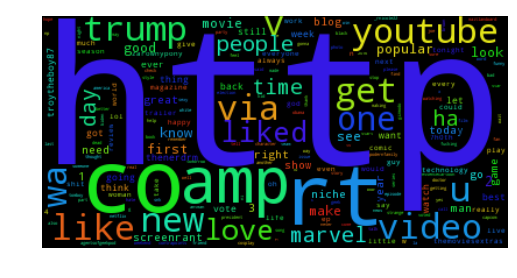

In [12]:
import wordcloud
import matplotlib.pylab as plt

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    names = v.get_feature_names()
    freqs = [np.sum(vs[:, i]) for i in xrange(len(names))]
    
    wc = wordcloud.WordCloud()
    im = wc.generate_from_frequencies([(w, freq) for w, freq in zip(names, freqs)])
    plt.imshow(im)
    plt.axis("off")
    plt.show()
    return

draw_tag_cloud(v, vs)